This notebook is meant as a rough tutorial for generating spectra using FSPS, playing around with its API, 
and multiplying spectra with filter curves to get magnitudes and photometry. 

In addition to the standard numpy, scipy, astropy and matplotlib libraries, it also uses FSPS and speclite.

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM

# import FSPS - this lets us generate galaxy spectral energy distributions 
# for a wide range of parameter values

import fsps

# import speclite - since FSPS doesn't have the LSST filter curves yet, 
# use this package to multiply spectra by the filter curves to get SEDs

import speclite


# Initialize a stellar population class using FSPS
This is the main class used to generate different spectra. To make changes to the dust, metallicity, etc. 
use the FSPS API, available at dan.iel.fm/python-fsps/current/stellarpop_api/#api-reference

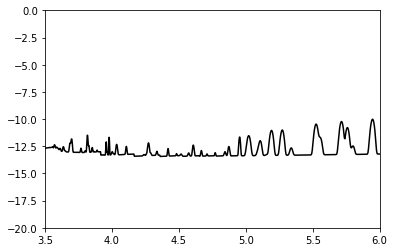

In [3]:
sp = fsps.StellarPopulation(compute_vega_mags=False, zcontinuous=1,sfh=0, imf_type=1, logzsol=0.0, dust_type=2, dust1=0.0, dust2=0.0, add_neb_emission=True,add_neb_continuum=True)

# first initialization and check
[lam,ssp_spec] = sp.get_spectrum(tage = 0.0001)
plt.plot(np.log10(lam),np.log10(ssp_spec),'k-')
plt.axis([3.5, 6, -20, 0])
plt.show()

lam_arr = lam * u.Angstrom
spec_arr = ssp_spec * u.erg / (u.cm**2 * u.s * u.Angstrom)

#sp.libraries

<style TYPE="text/css">
code.has-jax {font: inherit; font-size: 100%; background: inherit; border: inherit;}
</style>
<script type="text/x-mathjax-config">
MathJax.Hub.Config({
    tex2jax: {
        inlineMath: [['$','$'], ['\\(','\\)']],
        skipTags: ['script', 'noscript', 'style', 'textarea', 'pre'] // removed 'code' entry
    }
});
MathJax.Hub.Queue(function() {
    var all = MathJax.Hub.getAllJax(), i;
    for(i = 0; i < all.length; i += 1) {
        all[i].SourceElement().parentNode.className += ' has-jax';
    }
});
</script>
<script type="text/javascript" src="http://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML"></script>

# Import the LSST ugrizy filter set, and get SEDs
plot the filter curves to get an idea of where they lie in wavelength space and what their shapes are.
write a couple of functions to convert the $L_\nu$ output of FSPS to $F_\nu$ in $\mu Jy$, and do the same for SEDs.

This can be integrated further by creating an SED class and building this into the class.

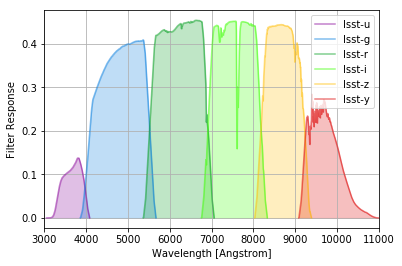

In [7]:
lsst = speclite.filters.load_filters('lsst2016-*')

# central wavelengths of the LSST filters
centers_lsst = np.array([3664.37, 4807.02, 6209.82, 7542.84, 8700.52, 9633.00]);    

speclite.filters.plot_filters(lsst, wavelength_limits=(3000, 11000))
plt.show()

In [5]:
def convert_to_microjansky(spec,z,cosmology):
    return spec *1e6 * 1e23*3.48e33/(4*np.pi*3.086e+24*3.086e+24*cosmo.luminosity_distance(z).value*cosmo.luminosity_distance(z).value)

def calc_sed_lsst(mags):
    sed = np.zeros((6,))
    centers_lsst = np.array([3664.37, 4807.02, 6209.82, 7542.84, 8700.52, 9633.00]);    
    for i in range(6):
        sed[i] = np.power(10,(mags[0][i] + 48.600)*(-2/5))/(3.34e4*centers_lsst[i]*centers_lsst[i]/1e23)
    return sed

In [6]:
redshift_val = 1
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
print(cosmo.age(redshift_val))

mags = lsst.get_ab_magnitudes(convert_to_microjansky(ssp_spec,redshift_val,cosmo), lam*(1+redshift_val))

mags

5.7516469434010205 Gyr


lsst-u,lsst-g,lsst-r,lsst-i,lsst-z,lsst-y
float64,float64,float64,float64,float64,float64
-0.784924204093,-1.15530532227,-1.73963352842,-2.35187325018,-2.12721376817,-3.49800427611


now plot a figure of the spectrum and SED for consistency

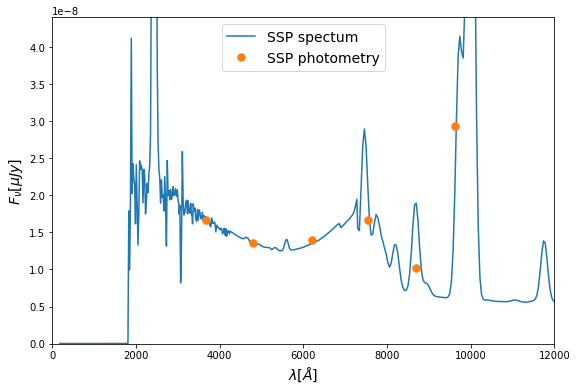

In [10]:
fig = plt.figure(figsize=(9,6))
plt.plot((lam_arr.value*(1+redshift_val)),convert_to_microjansky(ssp_spec,redshift_val,cosmo),label='SSP spectum')
plt.plot((centers_lsst),calc_sed_lsst(mags),'.',markersize=15,label = 'SSP photometry')
plt.axis([0,12000,0,np.amax(calc_sed_lsst(mags))*1.5])
plt.xlabel(r'$\lambda [\AA]$',fontsize = 14)
plt.ylabel(r'$F_\nu [\mu Jy]$',fontsize = 14)
plt.legend(fontsize=14)
plt.show()



# now play around with the FSPS API for a bit, 
try different metallicities and turning off and on nebular emission lines to see the effect on SEDs, 
as well as trying different redshifts to see when an emission line would hit two filters simulataneously,
or a couple of emission lines hit two different filters for a given redshift range.

In [19]:
redshift_val = 0.5

# use this to add Madau IGM absorption to the spectrum
sp.params['add_igm_absorption'] = True
sp.params['zred'] = redshift_val

# this sets the value of metallicity, in units of log Z*/Z_solar
sp.params['logzsol'] = 0.0

# this sets the value of dust reddening, as the Av parameter for the Calzetti extinction law
sp.params['dust2'] = 0.2


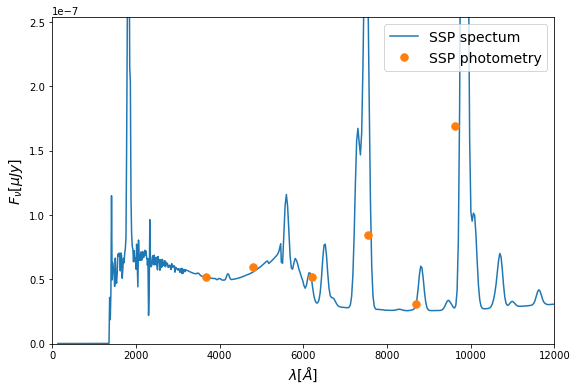

In [20]:
[lam,ssp_spec] = sp.get_spectrum(tage = 0.001)
mags = lsst.get_ab_magnitudes(convert_to_microjansky(ssp_spec,redshift_val,cosmo), lam*(1+redshift_val))

fig = plt.figure(figsize=(9,6))
plt.plot((lam_arr.value*(1+redshift_val)),convert_to_microjansky(ssp_spec,redshift_val,cosmo),label='SSP spectum')
plt.plot((centers_lsst),calc_sed_lsst(mags),'.',markersize=15,label = 'SSP photometry')
plt.axis([0,12000,0,np.amax(calc_sed_lsst(mags))*1.5])
plt.xlabel(r'$\lambda [\AA]$',fontsize = 14)
plt.ylabel(r'$F_\nu [\mu Jy]$',fontsize = 14)
plt.legend(fontsize=14)
plt.show()

In [ ]:
# add code to now go into Cloudy to model emission lines in much more detail instead of using
# the pre-grid that FSPS has.  